## **EN2550 Assignment 2 on Fitting and Alignment** 
### *by Rajapaksha R.M.P.A.P. - 190484T* 


In [4]:
# importing libraries 
import numpy as np
from scipy import linalg 
from scipy.optimize import minimize 
import cv2 as cv 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [14]:
def isInlier(coord1, center, r, t):
     "return whether a given point (coord1) is an inlier or not of the circle with center (center) and radius (r) w.r.t a threshold distance (t)"
     x, y = coord1; xO, yO = center
     distance_from_circumference = np.abs(np.sqrt((x-xO)**2 + (y-yO)**2) - r)
     if (distance_from_circumference <= t): return True
     else: return False 

def RANSACcircle(points, N, t, d):
     "finds the best estimated circle for a given point set using RANSAC method" 
     trial = 0
     estimatedCircleDict = {} 
     while (trial < N): 
          # randomly choose a set of 3 points from the point set.
          sample_indices = np.random.randint(0, len(points), 3) 
          "if the chosen points are not distinct, then reject the sample and take a new one." 
          if (len(set(sample_indices)) < 3): N += 1; continue 
          sample = [points[i] for i in sample_indices] 
          x1, y1 = sample[0]; x2, y2 = sample[1]; x3, y3 = sample[2]

          # finding the circumcenter of the triangle
          A = np.array([[(x1-x2), (y1-y2)], 
                        [(x1-x3), (y1-y3)]])
          B = np.array([[1/2 * (x1**2-x2**2 + y1**2-y2**2)],
                        [1/2 * (x1**2-x3**2 + y1**2-y3**2)]])
          center = ((np.linalg.inv(A) @ B).T).reshape(2) 
          xO = center[0]; yO = center[1] 

          # finding the radius of the circumscribed circle 
          r = np.sqrt((x1-xO)**2 + (y1-yO)**2) 

          """if the radius of the estimated circle is greater than 12 (half of the width of the region of point distribution), 
          or xO and yO are out of the [-12, 12] interval, reject the circle as invalid. """
          if (r > 12) or not (-12 <= xO <= 12) or not (-12 <= yO <= 12): continue 

          # finding the inlier count 
          inlier_count = 0
          for point in points: 
               if isInlier(point, center, r, t): inlier_count += 1

          # if the inlier count exceeds the consensus set size (d), add the estimated circle with the inlier count to the dict
          if (inlier_count >= d): estimatedCircleDict[inlier_count] = (center, r)

          trial += 1 # process is complete for the selected sample. 

     # finally, return the circle with the maximum inlier count as the best fitting circle. 
     return estimatedCircleDict[max(estimatedCircleDict.keys())]  

In [10]:
# ************************** question 1 ***************************** 
N = 100     # total number of points 
half_n = N//2 

# creating a cluster of random points around a known circle 
r = 10      # radius 
s = r/16    # variance 

t = np.random.uniform(0, 2*np.pi, half_n) 
n = s * np.random.randn(half_n) 

x, y = (r+n)*np.cos(t), (r+n)*np.sin(t) 
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# creating a cluster of random points around a known straight line 
m, b = -1, 2
x = np.linspace(-12, 12, half_n) 
y = m*x + b + s*np.random.rand(half_n) 
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1))) 
X = np.vstack((X_circ, X_line)) 

In [17]:
# ---------- tuning the parameters --------- 
N = 35      # number of estimations 
t = 1.225   # common threshold 
d = 47      # minimum inlier count 

# finding the best fitting circle
print(RANSACcircle(X, N, t, d)) 
(center, radius) = RANSACcircle(X, N, t, d) 
xo, yo = center

(array([0.06965707, 0.37970716]), 9.52932515578044)


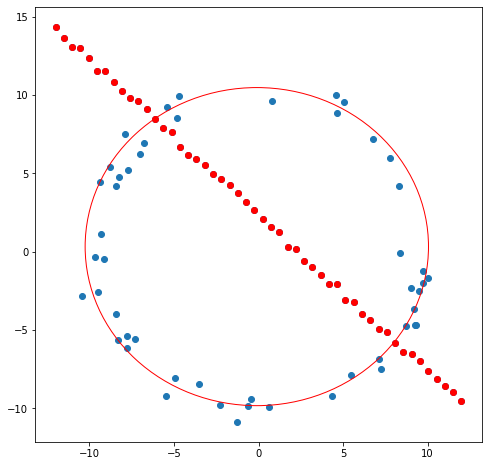

In [19]:
# plotting the results 
bestFitCircle = plt.Circle(center, radius, color='r', fill = False) 

fig, ax = plt.subplots(figsize = (8, 8)) 
ax.add_patch(bestFitCircle)
ax.scatter(X[:, 0], X[:, 1], marker = 'o') 
ax.scatter(X_line[:, 0], X_line[:, 1], c = 'r', marker = 'o') 

#### Using RANSAC method for finding the best fitting circle 
- step 1 - randomly choose an $s$ number of points from the cluster.
    > + In case of fitting a circle, the number of points to be chosen is 3 $[s=3]$. This is due to the fact that for every three distinct points in the 2D space, there is always a single circle that connects all of the three points together. This circle is known as the *circumscribed circle* of the triangle formed by the 3 points. 
- step 2 - fit a model to the selected points. 
    > + As discussed earlier, the fitting model is the circumscribed circle. 
- step 3 - finding the *Inlier* count of the model. 
    > + Here, the Inliers are the points that reside within a certain threshold distance, $t$ from the circumference of the estimated circle. 
    > + As given in the code snippet *Listing 1*, the random points that surround the circumference of the circle are distributed according to a *normal/Gaussian distribution* with a *variance* $\sigma$ equal to $1/16$ times the radius of the original circle. 
    > + Assume that somehow the above information about the point distribution is given to us. Then we can find an expression for the threshold value $t$ in terms of the radius of the estimated circle $r$, such that $95$% of the points that correspond to the circle are covered by the threshold limit.   
          $ t = 1.96\sigma \, {\small (from \: Standard \: Normal \: Distribution \: Tables)}
                \Longrightarrow t = 1.96 \times r/16 = 0.1225 \, r$ 
    > + Furthermore, if we assume that the estimated circle has a radius around length $10$ (as given in the code), then a single value can be given as a common threshold for all estimations.  
          $ t_{common} = 0.1225 \times 10 = 1.225
     $ 
    
- step 4 - if there are $d$ or more inliers, then accept the estimation. 
    > + To decide whether an estimation is exactly a best fitting model, its inlier count must exceed a certain limit, which is known as the *consensus set size* $d$. The consensus set size depends on the *inlier ratio* of the distribution. 
    > + As given in the code snippet, there are $50$ points resembling the shape of the circle. Then, since the best fitting model is expected to cover at least a $95$% of the points resembling the circle, the consensus set size can be found as 
            $ d = 0.95 \times halfn = 0.95 \times 50 = 47.5 \backsimeq 47 $ 

This process has to be repeated for a number of times to ensure that there is a sufficient probability for at least one sample to be free of any outliers. 
If the targeted probability of having at least one successful uncontaminated estimation is $p$ and the outlier ratio is $e$, then the number of repetition required to achieve $p$ is given by the following equation. 
        $ N = log(1-p) / log(1 - (1-e)^s) 
    $

Let us assume a reasonably higher $p$ value as $0.99$ [i.e. a $99$% success rate]. And it is easier to see that the outlier ratio $e$ is equal to $50$% because there are an equal number of points resembling the circle and the straight line. Thus, a minimum value for $N$ can be found out as follows. 
        $ N = log(1-0.99) / log(1 - (1-0.5)^3) \Longrightarrow N = 34.48 \backsimeq 35
    $ 

#### Using RANSAC method for finding the best fitting circle 
<font size="2"> 

- step 1 - randomly choose an $s$ number of points from the cluster.
> + In case of fitting a circle, the number of points to be chosen is 3 $[s=3]$. 
- step 2 - fit a model to the selected points. 
> + In this case, the fitting model is the *circumscribed circle* of the triangle formed by the selected 3 points. 
- step 3 - finding the *Inlier* count of the model. 
> + Here, the Inliers are the points that reside within a certain threshold distance, $t$ from the circumference of the estimated circle. 
> + As given in the code snippet *Listing 1*, the random points that surround the circumference of the circle are distributed according to a *normal/Gaussian distribution* with a *variance* $\sigma$ equal to $1/16$ times the radius of the original circle. 
> + Assume that somehow the above information about the point distribution is given to us. Then we can find an expression for the threshold value $t$ in terms of the radius of the estimated circle $r$, such that $95$% of the points that correspond to the circle are covered by the threshold limit.   
> $ t = 1.96\sigma \ {\small (from \ Standard \ Normal \ Distribution \ Tables)} \Longrightarrow t = 1.96 \times r/16 = 0.1225 \ r$ 
> + Furthermore, if we assume that the estimated circle has a radius around length $10$ (as given in the code), then a single value can be given as a common threshold for all estimations.  
> $ t_{common} = 0.1225 \times 10 = 1.225 $ 
    
- step 4 - if there are $d$ or more inliers, accept the estimation. 
> + To decide whether an estimation is exactly a best fitting model, its inlier count must exceed a certain limit, which is known as the *consensus set size* $d$. The consensus set size depends on the *inlier ratio* of the distribution. 
> + As given in the code snippet, there are 50 points resembling the shape of the circle. Then, since the best fitting model is expected to cover at least a 95% of the points resembling the circle, the consensus set size can be found as 
$ d = 0.95 \times halfn = 0.95 \times 50 = 47.5 \backsimeq 47 $. 

This process has to be repeated for a number of times to ensure that there is a sufficient probability for at least one sample to be free of any outliers. 
If the targeted probability of having at least one successful uncontaminated estimation is $p$ and the outlier ratio is $e$, then the number of repetition required to achieve $p$ is given by the equation; 
$ N = log(1-p) / log(1 - (1-e)^s) $ 

Let us assume a reasonably higher $p$ value as $0.99$ [i.e. a $99$% success rate]. And it is easier to see that the outlier ratio $e$ is equal to $50$% because there are an equal number of points resembling the circle and the straight line. Thus, a minimum value for $N$ can be found out as follows. 
$ N = log(1-0.99) / log(1 - (1-0.5)^3) \Longrightarrow N = 34.48 \backsimeq 35 $ </font>

#### Using RANSAC method for finding the best fitting circle 
<font size="2"> 

- step 1 - randomly choose a set of 3 points from the data set.
- step 2 - find the *circumscribed circle* of the triangle formed by the selected 3 points. 
- step 3 - finding the *Inlier* count of the model. 
> + Here, the Inliers are the points that reside within a certain threshold distance $t$ from the circumference of the estimated circle. 
> + As given in the code snippet *Listing 1*, the random points that surround the circumference of the circle are distributed according to a *normal/Gaussian distribution* with a *variance* $\sigma$ equal to $1/16$ times the radius of the original circle. 
> + Assume that somehow the above information about the point distribution is given to us. Then we can find an expression for the threshold value $t$ in terms of the radius of the estimated circle $r$, such that $95$% of the points that correspond to the circle are covered by the threshold limit.   
> $ t = 1.96\sigma \ {\small (from \ Standard \ Normal \ Distribution \ Tables)} \Longrightarrow t = 1.96 \times r/16 = 0.1225 \ r$ 
> + Furthermore, if we assume that the estimated circle has a radius around length $10$ (as given in the code), then a single value can be given as a common threshold for all estimations.  
> $ t_{common} = 0.1225 \times 10 = 1.225 $ 
- step 4 - if there are $d$ or more inliers, accept the estimation. 
> + To decide whether an estimation is exactly a good fitting model, its inlier count must exceed a certain limit, which is known as the *consensus set size* $d$. The consensus set size depends on the *inlier ratio* of the distribution. 
> + As given in the code, there are 50 points resembling the shape of the circle. Then, since the best fitting model is expected to cover at least a 95% of the points resembling the circle, the consensus set size can be found as 
$ d = 0.95 \times halfn = 0.95 \times 50 = 47.5 \backsimeq 47 $. 

This process has to be repeated for a number of times to ensure that there is a sufficient probability for at least one sample to be free of any outliers. 
If the targeted probability of having at least one successful uncontaminated estimation is $p$ and the outlier ratio is $e$, then the number of repetition required to achieve $p$ is given by the equation; 
$ N = log(1-p) / log(1 - (1-e)^s) $ 

Let us assume a reasonably higher $p$ value as $0.99$ [i.e. a $99$% success rate]. And it is easier to see that the outlier ratio $e$ is equal to $50$% because there are an equal number of points resembling the circle and the straight line. Thus, a minimum value for $N$ can be found out as follows. 
$ N = log(1-0.99) / log(1 - (1-0.5)^3) \Longrightarrow N = 34.48 \backsimeq 35 $ </font>